# 1 - Normalização e Pré-processamento:

Normalizem as observações para estarem dentro de um intervalo razoável.

Convertam as ações em um formato compatível com o ambiente e criem as funções de cada ação.
Identifiquem as features relevantes que podem ajudar o agente a aprender melhor.

Extraíam e processem essas features a partir dos dados brutos, se necessário, para facilitar o aprendizado do agente.

## Importação

In [58]:
import warnings

# Ignore DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# IMPORTANTE: Coloque os arquivos fornecidos pelo parceiro em uma pasta chamada "Data", na raiz do seu Google Drive
# Os arquivos .xlsx abaixo foram tratados previamente a partir do .xlsb enviados pelo ciente
# Consistem em ações filtradas no Excel para que constem apenas ações VALE3 (Vale ON) do CLIENTE 4 da corretora FUTU (Nova Futura) da base 2023.

spot_path  = '/content/drive/MyDrive/Data/2023_COMPRA_C4_VALE3_FUTU.xlsx'
futures_path = '/content/drive/MyDrive/Data/2023_VENDA_C4_VALE3_FUTU.xlsx'

In [61]:
# Bibliotecas de análise
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [62]:
# Arquivo de compras - mercado "spot" (à vista)
df_spot = pd.read_excel(spot_path)
# Arquivo de vendas - mercado de "futures" (a termo)
df_futures = pd.read_excel(futures_path)

In [63]:
print(df_spot.head())
df_spot.dtypes

  Cód. Cliente Dt. Operação Tipo Operação Cód. Título Cód. Corretora  \
0    Cliente 4   2023-07-28             C       VALE3           FUTU   
1    Cliente 4   2023-07-28             C       VALE3           FUTU   
2    Cliente 4   2023-11-08             C       VALE3           FUTU   
3    Cliente 4   2023-09-21             C       VALE3           FUTU   
4    Cliente 4   2023-05-23             C       VALE3           FUTU   

   Quantidade      Preço  Valor Líquido Dt. Liquidação Tipo  
0         500  68.765780      -34382.89     2023-08-01   AV  
1        1500  68.865820     -103298.73     2023-08-01   AV  
2        2000  70.096110     -140192.22     2023-11-10   AV  
3       10000  67.815595     -678155.95     2023-09-25   AV  
4        2000  66.915825     -133831.65     2023-05-25   AV  


Cód. Cliente              object
Dt. Operação      datetime64[ns]
Tipo Operação             object
Cód. Título               object
Cód. Corretora            object
Quantidade                 int64
Preço                    float64
Valor Líquido            float64
Dt. Liquidação    datetime64[ns]
Tipo                      object
dtype: object

In [64]:
print(df_futures.head())
df_futures.dtypes

    Chave Cód. Cliente Dt. Operação Tipo Operação Cód. Título Cód. Corretora  \
0   5048A    Cliente 4   2023-02-10             V       VALE3           FUTU   
1   6431A    Cliente 4   2023-10-04             V       VALE3           FUTU   
2   6432A    Cliente 4   2023-10-04             V       VALE3           FUTU   
3  13878A    Cliente 4   2023-04-20             V       VALE3           FUTU   
4  13879A    Cliente 4   2023-04-20             V       VALE3           FUTU   

   Quantidade      Preço  Valor Líquido Vencimento Tipo        DI  
0         575  89.022087       51187.70 2023-04-25   TE  0.136535  
1          53  66.586981        3529.11 2023-11-03   TE  0.126429  
2          53  66.586981        3529.11 2023-11-03   TE  0.126429  
3         978  76.640153       74954.07 2023-06-19   TE  0.136376  
4          22  76.650909        1686.32 2023-06-19   TE  0.136376  


Chave                     object
Cód. Cliente              object
Dt. Operação      datetime64[ns]
Tipo Operação             object
Cód. Título               object
Cód. Corretora            object
Quantidade                 int64
Preço                    float64
Valor Líquido            float64
Vencimento        datetime64[ns]
Tipo                      object
DI                       float64
dtype: object

## Feature Engineering

## Computar Valor Presente do Termo (Preço 100% do DI)

In [65]:
!pip install pandas-market-calendars # biblioteca para pegar os dias úteis do ano para cálculo do valor descontado

In [66]:
import pandas_market_calendars as mcal

# Pre-computar o calendário da BMF (B3)
# TODO: alguns dias desse calendário não batem com a planilha enviada pelo parceiro, talvez alguns feriados
# estão sendo contabilizados e outros não. Verificar qual calendário o parceiro usa internamente.
# De qualquer forma como é normalmente apenas um dia a mais ou a menos, isso não impacta o cálculo final.
bmf_calendar = mcal.get_calendar('BMF')

def business_days(start, end, calendar):
    """
    Computa os dias úteis (DU) entre duas datas.
    """
    schedule = calendar.schedule(start_date=start, end_date=end)
    return len(schedule)

# Adicionar uma coluna com o número dos dias úteis  a column with the number of business days until expiration for each row
df_futures['DU'] = df_futures.apply(
    lambda row: business_days(row['Dt. Operação'], row['Vencimento'], bmf_calendar), axis=1)

# Computar o Valor Presente (VP) do Preço com base na data de vencimento e na taxa DI do dia
df_futures['VP Preço'] = df_futures['Preço'] / (1 + df_futures['DI']) ** (df_futures['DU'] / 252)

def compute_pv_future(row):
    """
    Computa o Valor Presente (PV) do termo sob análise com base em um rendimento 100% da taxa DI do dia da operação do Termo.
    """
    DI_rate = row['DI'] # em %

    # Cria uma instância do calendário BM&F
    bmf_calendar = mcal.get_calendar('BMF')

    # Gera um DataFrame dos dias úteis entre as datas de início e fim
    schedule = bmf_calendar.schedule(start_date=row['Dt. Operação'], end_date=row['Vencimento'])

    # Calcula o número de dias úteis como o tamanho desse DataFrame
    days_until_expiration = len(schedule)

    # Calcula o PV do futuro com base no número de dias úteis
    pv_future = row['Preço'] / (1 + DI_rate) ** (days_until_expiration / 252)

    return pv_future

In [67]:
df_futures[df_futures['Dt. Operação'] == '2023-07-28']
df_futures.sort_values(by='Dt. Operação', ascending=True)

,Chave,Cód. Cliente,Dt. Operação,Tipo Operação,Cód. Título,Cód. Corretora,Quantidade,Preço,Valor Líquido,Vencimento,Tipo,DI,DU,VP Preço
0,5048A,Cliente 4,2023-02-10,V,VALE3,FUTU,575,89.022087,51187.70,2023-04-25,TE,0.136535,49,86.834037
11,26059A,Cliente 4,2023-02-10,V,VALE3,FUTU,425,89.032118,37838.65,2023-04-25,TE,0.136535,49,86.843821
3,13878A,Cliente 4,2023-04-20,V,VALE3,FUTU,978,76.640153,74954.07,2023-06-19,TE,0.136376,40,75.100591
4,13879A,Cliente 4,2023-04-20,V,VALE3,FUTU,22,76.650909,1686.32,2023-06-19,TE,0.136376,40,75.111130
5,13882A,Cliente 4,2023-04-25,V,VALE3,FUTU,160,70.834000,11333.44,2023-05-25,TE,0.136492,22,70.047194
6,13883A,Cliente 4,2023-04-25,V,VALE3,FUTU,40,70.844000,2833.76,2023-05-25,TE,0.136492,22,70.057083
7,13884A,Cliente 4,2023-04-25,V,VALE3,FUTU,980,72.033122,70592.46,2023-06-19,TE,0.136352,38,70.657982
8,13885A,Cliente 4,2023-04-25,V,VALE3,FUTU,20,72.044500,1440.89,2023-06-19,TE,0.136352,38,70.669143
49,38932A,Cliente 4,2023-05-10,V,VALE3,FUTU,23,71.114348,1635.63,2023-07-10,TE,0.136399,43,69.579571
48,38931A,Cliente 4,2023-05-10,V,VALE3,FUTU,177,71.101073,12584.89,2023-07-10,TE,0.136399,43,69.566583


### Limpeza

Os seguintes dados não são necesários para nossa análise e podem ser removidos completamente:

#### Planilha de Compra à vista (df_spot)

- Cód. Cliente: já foi filtrado previamente
- Dt. Liquidação: não importa, só a de operação
- Tipo Operação: todas são C
- Cód. Título: já foi filtrado previamente
- Cód. Corretora: já foi filtrado previamente
- Valor Líquido: não importa, pode ser calculado a partir da quantidade e preço
- Tipo: todos são AV

#### Planilha de Venda a termo (df_futures)

- Cód. Cliente: já foi filtrado previamente
- Tipo Operação: todas são V
- Cód. Título: já foi filtrado previamente
- Cód. Corretora: já foi filtrado previamente
- Tipo: todos são TE
- Valor Líquido: não importa, pode ser calculado a partir da quantidade e preço

In [68]:
df_spot = df_spot.drop(columns=['Cód. Cliente', 'Tipo Operação', 'Cód. Título', 'Cód. Corretora', 'Tipo', 'Valor Líquido', 'Dt. Liquidação'])
df_futures = df_futures.drop(columns=['Cód. Cliente', 'Tipo Operação', 'Cód. Título', 'Cód. Corretora', 'Valor Líquido', 'Tipo'])

# Vamos adicionar uma chave sintética também para a planilha spot, assim podemos saber que ações a termo estão vinculadas a ações à vista
df_spot.insert(0,'Chave','')
df_spot['Chave'] = df_spot.index.astype(int)

In [69]:
print(df_spot.head())
print(df_spot.dtypes)
print(df_futures.head())
print(df_futures.dtypes)

   Chave Dt. Operação  Quantidade      Preço
0      0   2023-07-28         500  68.765780
1      1   2023-07-28        1500  68.865820
2      2   2023-11-08        2000  70.096110
3      3   2023-09-21       10000  67.815595
4      4   2023-05-23        2000  66.915825
Chave                    int64
Dt. Operação    datetime64[ns]
Quantidade               int64
Preço                  float64
dtype: object
    Chave Dt. Operação  Quantidade      Preço Vencimento        DI  DU  \
0   5048A   2023-02-10         575  89.022087 2023-04-25  0.136535  49   
1   6431A   2023-10-04          53  66.586981 2023-11-03  0.126429  21   
2   6432A   2023-10-04          53  66.586981 2023-11-03  0.126429  21   
3  13878A   2023-04-20         978  76.640153 2023-06-19  0.136376  40   
4  13879A   2023-04-20          22  76.650909 2023-06-19  0.136376  40   

    VP Preço  
0  86.834037  
1  65.929635  
2  65.929635  
3  75.100591  
4  75.111130  
Chave                   object
Dt. Operação    datetime64

In [70]:
# Filtrar a data de operação para 27 de junho de 2023, para testes iniciais
df_futures = df_futures[df_futures['Dt. Operação'] == '2023-07-28']
df_futures.reset_index(drop=True, inplace=True)
df_futures

,Chave,Dt. Operação,Quantidade,Preço,Vencimento,DI,DU,VP Preço
0,36244A,2023-07-28,499,69.185050,2023-09-26,0.13226,42,67.767460
1,36245A,2023-07-28,1,69.200000,2023-09-26,0.13226,42,67.782104
2,36246A,2023-07-28,182,70.224396,2023-09-26,0.13226,42,68.785510
3,36247A,2023-07-28,818,70.234340,2023-09-26,0.13226,42,68.795250
4,36248A,2023-07-28,599,70.354257,2023-09-26,0.13226,42,68.912710
5,36249A,2023-07-28,901,70.364262,2023-09-26,0.13226,42,68.922510


In [71]:
df_spot = df_spot[df_spot['Dt. Operação'] == '2023-07-28']
df_spot.reset_index(drop=True, inplace=True)
df_spot

,Chave,Dt. Operação,Quantidade,Preço
0,0,2023-07-28,500,68.76578
1,1,2023-07-28,1500,68.86582
2,12,2023-07-28,500,67.71556
3,25,2023-07-28,500,68.71578


## Normalização e Features

Não podemos normalizar os dados existentes, pois eles devem ser exatos por um ou outro motivo:

- Se modificarmos as datas de vencimento ou de liquidação, isso tornará difícil estabelecer uma regra de que a liquidação tem que ocorrer antes do vencimento.

- Se modificarmos a taxa DI, será difícil construir a curva do valor descontado.

- Se normalizarmos a quantidade ou o preço, não conseguiremos estabelecer o valor exato de ações que deverão ser vinculadas por um valor específico e o parceiro precisa dessa informação.

As features serão, portanto:

- Chave das ações à vista e a termo
- Quandidade das ações disponíveis à vista e a termo
- Data de liquidação da ação à vista
- Data de vencimento da ação a termo
- Taxa DI da ação a termo

# 2 - Estabelecimento de Critérios e Função de Recompensa:

Estabeleçam critérios claros para definir um episódio.
Descrevam detalhadamente a função de recompensa.
Desenvolvam uma variável de classe "env" para iniciar as simulações durante o treinamento.

## Criar o Ambiente no Gym

In [72]:
import gym # v0.25.2
from gym import spaces
import numpy as np

class CashAndCarryArbitrageEnv(gym.Env):
    """Ambiente personalizado para Arbitragem de Cash and Carry usando a biblioteca gym"""

    def __init__(self, df_futures=pd.DataFrame(), df_spot=pd.DataFrame(), max_spot_stocks=20, max_cycles=5):
        super(CashAndCarryArbitrageEnv, self).__init__()

        # Copiar dataframes de referência
        self.df_futures = df_futures.copy()
        self.df_spot = df_spot.copy()
        # Número máximo de ações à vista
        self.max_spot_stocks = max_spot_stocks
        self.max_cycles = max_cycles

        # Definir espaço de ação
        # 0: combinar,
        # 1: descombinar,
        self.action_space = spaces.Discrete(2)

        # Definir espaço de observação
        self.observation_space = spaces.Dict(
            {
                "future_index": spaces.Discrete(len(self.df_futures)), # Indice da ação a termo atualmente sob análise
                "spot_index": spaces.Discrete(len(self.df_spot)), # Indice da ação a vista atualmente sob análise
                "spot_price": spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32), # Preço do spot atual
                "future_price_pv": spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32), # Preço trazido para o presente do futuro
                "profit_ratio": spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32), # Rentabilidade (Preço do spot / Preço presente do futuro)
                "future_quantity": spaces.Discrete(self.df_futures['Quantidade'].max() + 1), # Quantidade disponível para combinar do termo atual
                "available_future_stocks": spaces.Discrete(self.df_futures['Quantidade'].sum() + 1), # Quantidade de acoes future disponíveis
                "available_spot_stocks": spaces.Box(low=0, high=np.inf, shape=(self.max_spot_stocks,), dtype=np.int64), # Quantidade de ações spot disponíveis para esse termo
                "selected_spot_stocks": spaces.Box(low=0, high=np.inf, shape=(self.max_spot_stocks,), dtype=np.int64), # Quantidade de ações spot selecionadas para esse termo
            }
        )

        # Inicializar estado do ambiente
        self.state = {}

    def step(self, action):
        self._check_state_against_observation_space(self.state, self.observation_space)

        # Interpretar as ações possíveis
        matching = action == 0
        unmatching = action == 1

        # Inicializar a recompensa como -1 (punir demora)
        reward = -1

        # Transformar os dados do estado em variáveis
        future_index = self.state['future_index']
        spot_index = self.state['spot_index']
        spot_price = self.state['spot_price']
        future_pv = self.state['future_price_pv']
        profit_ratio = self.state['profit_ratio']
        future_quantity = self.state['future_quantity']
        available_future_stocks = self.state['available_future_stocks']
        available_spot_stocks = self.state['available_spot_stocks']
        selected_spot_stocks = self.state['selected_spot_stocks']

        # Unwrapper para valores escalares
        self.state['spot_price'] = self.state['spot_price'][0]
        self.state['future_price_pv'] = self.state['future_price_pv'][0]
        self.state['profit_ratio'] = self.state['profit_ratio'][0]

        if matching:
            # Selecionar um futuro e uma ação spot específicos e realizar a combinação
            spot_quantity = available_spot_stocks[spot_index]

            # Se as ações à vista disponíveis excederem as ações a termo, use só as ações remanescentes que tiver
            if future_quantity < spot_quantity:
                spot_quantity = future_quantity

            # Adiciona esse stock ao dicionário de combinações
            self.matches[future_index][spot_index][0] += spot_quantity

            # Reduz a quantidade de acoes future disponiveis para combinacao
            self.state['available_future_stocks'] -= spot_quantity
            self.df_futures.at[future_index, 'Quantidade'] -= spot_quantity
            self.state['future_quantity'] -= spot_quantity

            # Muda os spots de disponível para selecionados
            self.state['available_spot_stocks'][spot_index] -= spot_quantity
            self.state['selected_spot_stocks'][spot_index] += spot_quantity

            # Calcular a recompensa
            # Não recompensar caso tente fazer uma combinação impossível (spot_quantity == 0)
            if (spot_quantity != 0):
                reward += self._calculate_reward(profit_ratio)
        elif unmatching:
            # Fazer o caminho contrário do 'match' acima
            spot_quantity = selected_spot_stocks[spot_index]

            # Nesse caso não é necessário verificar se vamos exceder as ações a termo disponíveis

            # Remover a quantidade de spots do dicionário de combinações
            self.matches[future_index][spot_index][0] -= spot_quantity

            # Restaura a quantidade de acoes future disponiveis para combinacao
            self.state['available_future_stocks'] += spot_quantity
            self.df_futures.at[future_index, 'Quantidade'] += spot_quantity
            self.state['future_quantity'] += spot_quantity

            # self.df_spot.at[spot_index, 'Quantidade'] += spot_quantity

            # Muda os spots de selecionados para disponíveis
            self.state['selected_spot_stocks'][spot_index] -= spot_quantity
            self.state['available_spot_stocks'][spot_index] += spot_quantity

            # Calcular a recompensa
            # Não recompensar caso tente fazer uma combinação impossível (spot_quantity == 0)
            if (spot_quantity != 0):
                # Se era uma combinação ruim, ganha pontos. Se era boa, perde pontos.)
                reward -= self._calculate_reward(profit_ratio)
            # Punição leve, para incentivar combinações
            reward -= 9

        # Passar para a próxima combinação

        # Escolhe o próximo spot
        self.state['spot_index'] += 1

        # Se já tiver passado por todos os spots, escolhe o próximo future
        if self.state['spot_index'] >= len(self.df_spot):
            self.cycles += 1
            self.state['future_index'] += 1 # Vai para o próximo future
            if self.state['future_index'] >= len(self.df_futures):
                self.state['future_index'] = 0
            self.state['spot_index'] = 0
            self.state['future_price_pv'] = self.df_futures.at[self.state['future_index'], 'VP Preço']
            self.state['future_quantity'] = self.df_futures.at[self.state['future_index'], 'Quantidade']
            # available_spot_stocks = self.df_spot['Quantidade'].to_numpy()
            # self.state['available_spot_stocks'] = np.pad(available_spot_stocks, (0, self.max_spot_stocks - len(available_spot_stocks)), 'constant')
            # Loop pelo objeto de matches para pegar as combinações já feitas
            self.state['selected_spot_stocks'] = np.zeros(self.max_spot_stocks, dtype=np.int64)
            for i in range(len(self.matches[self.state['future_index']])):
                self.state['selected_spot_stocks'][i] = self.matches[self.state['future_index']][i][0]

        # Calcula o retorno (em % do CDI), se ainda não foi calculado
        self.state['spot_price'] = self.df_spot.at[self.state['spot_index'], 'Preço']
        if self.matches[self.state['future_index']][self.state['spot_index']][1] == 0:
            self.state['profit_ratio'] = self.state['spot_price'] / self.state['future_price_pv']
            self.matches[self.state['future_index']][self.state['spot_index']][1] = self.state['profit_ratio']
        else:
            self.state['profit_ratio'] = self.matches[self.state['future_index']][self.state['spot_index']][1]

        # Verifica se todos os futures já foram combinados ou se o ciclo foi encerrado
        # caso positivo, encerra o episodio
        if self.state['available_future_stocks'] == 0 or self.cycles >= self.max_cycles * len(self.df_futures):
            self.done = True

        # Wrapper para valores escalares
        self.state['spot_price'] = np.array([self.state['spot_price']], dtype=np.float32)
        self.state['future_price_pv'] = np.array([self.state['future_price_pv']], dtype=np.float32)
        self.state['profit_ratio'] = np.array([self.state['profit_ratio']], dtype=np.float32)

        return self.state, reward, self.done, {} # retorna 0 como recompensa

    def reset(self):
        # Resetar estado dos dataframe
        self.df_futures = df_futures.copy()
        self.df_spot = df_spot.copy()

        self.state['future_index'] = np.random.randint(0, len(self.df_futures)) # Escolhe um future aleatoriamente
        self.state['spot_index'] = 0
        self.state['spot_price'] = self.df_spot.at[self.state['spot_index'], 'Preço']
        self.state['future_price_pv'] = self.df_futures.at[self.state['future_index'], 'VP Preço']
        self.state['profit_ratio'] = self.state['spot_price'] / self.state['future_price_pv']
        self.state['future_quantity'] = self.df_futures.at[self.state['future_index'], 'Quantidade']
        available_spot_stocks = self.df_spot['Quantidade'].to_numpy()
        self.state['available_future_stocks'] = self.df_futures['Quantidade'].sum()
        self.state['available_spot_stocks'] = np.pad(available_spot_stocks, (0, self.max_spot_stocks - len(available_spot_stocks)), 'constant')
        self.state['selected_spot_stocks'] = np.zeros(self.max_spot_stocks, dtype=np.int64)

        self.matches = [ [[0, 0] for _ in range(len(self.df_spot))] for _ in range(len(self.df_futures)) ] # lista com as combinações, para salvar na memória e para verificar performance
        self.matches[self.state['future_index']][self.state['spot_index']][1] = self.state['profit_ratio']

        # Wrapper para valores escalares
        self.state['spot_price'] = np.array([self.state['spot_price']], dtype=np.float32)
        self.state['future_price_pv'] = np.array([self.state['future_price_pv']], dtype=np.float32)
        self.state['profit_ratio'] = np.array([self.state['profit_ratio']], dtype=np.float32)

        # Contador de ciclos
        self.cycles = 0

        self.done = False

        return self.state

    def _calculate_reward(self, profit_ratio):
        """
        Calcula a recompensa com base na taxa de retorno.
        """

        reward = 100 # Recompensa padrão por uma combinação

        # Recompensa extra por uma combinação boa
        if 0.98 <= profit_ratio <= 1.04:
            reward += 100
            if 1 <= profit_ratio <= 1.01:
                reward += 100

        return reward

    def _check_state_against_observation_space(self, state, observation_space):
        for key, value in state.items():
            expected_space = observation_space.spaces[key]

            if not expected_space.contains(value):
                print(f"Offending key: {key}")
                print(f"Offending value: {value}")
                print(f"Expected space: {expected_space}")
                raise ValueError(f"Key '{key}' with value {value} is outside the expected space {expected_space}")


## Registrar o Ambiente

In [73]:
from gym.envs.registration import register

register(
    id='CashAndCarryArbitrage-v0',
    entry_point='__main__:CashAndCarryArbitrageEnv',
)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment CashAndCarryArbitrage-v0
  logger.warn(f"Overriding environment {spec.id}")


## Instanciar o ambiente

In [74]:
env = gym.make('CashAndCarryArbitrage-v0', df_futures=df_futures, df_spot=df_spot)

In [75]:
state_size = (sum(1 for key, space in env.observation_space.spaces.items() if isinstance(space, spaces.Discrete))
              + sum(np.prod(space.shape) for key, space in env.observation_space.spaces.items() if isinstance(space, spaces.Box)))

# Verificar a quantidade de ações
num_actions = env.action_space.n

print("Tamanho do vetor de estados:", state_size)
print("Número de ações:", num_actions)

Tamanho do vetor de estados: 47
Número de ações: 2


In [76]:
initial_state = env.reset() # resetar ambiente

print("Estado:", initial_state)
print("Combinações:", env.matches)

Estado: {'future_index': 4, 'spot_index': 0, 'spot_price': array([68.76578], dtype=float32), 'future_price_pv': array([68.91271], dtype=float32), 'profit_ratio': array([0.9978679], dtype=float32), 'future_quantity': 599, 'available_future_stocks': 3000, 'available_spot_stocks': array([ 500, 1500,  500,  500,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0]), 'selected_spot_stocks': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}
Combinações: [[[0, 0], [0, 0], [0, 0], [0, 0]], [[0, 0], [0, 0], [0, 0], [0, 0]], [[0, 0], [0, 0], [0, 0], [0, 0]], [[0, 0], [0, 0], [0, 0], [0, 0]], [[0, 0.9978678762462074], [0, 0], [0, 0], [0, 0]], [[0, 0], [0, 0], [0, 0], [0, 0]]]


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


In [77]:
# Seleciona uma ação
# 0 - MATCH
# 1 - UNMATCH

action = 1

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, done, info = env.step(action)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Ação tomada:", action)
    print("Estado atual:", next_state)
    print("Recompensa recebida:", reward)
    print("Episódio terminou?:", done)
    print("Info:", info)
    print("Combinações: (Quantidade, Rentabilidade)")
    for idx, entry in enumerate(env.matches):
        print(f"Termo #{idx}: ", entry)

Ação tomada: 1
Estado atual: {'future_index': 4, 'spot_index': 1, 'spot_price': array([68.866], dtype=float32), 'future_price_pv': array([68.913], dtype=float32), 'profit_ratio': array([0.999], dtype=float32), 'future_quantity': 599, 'available_future_stocks': 3000, 'available_spot_stocks': array([ 500, 1500,  500,  500,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0]), 'selected_spot_stocks': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}
Recompensa recebida: -10
Episódio terminou?: False
Info: {}
Combinações: (Quantidade, Rentabilidade)
Termo #0:  [[0, 0], [0, 0], [0, 0], [0, 0]]
Termo #1:  [[0, 0], [0, 0], [0, 0], [0, 0]]
Termo #2:  [[0, 0], [0, 0], [0, 0], [0, 0]]
Termo #3:  [[0, 0], [0, 0], [0, 0], [0, 0]]
Termo #4:  [[0, 0.9978678762462074], [0, 0.9993195435828756], [0, 0], [0, 0]]
Termo #5:  [[0, 0], [0, 0], [0, 0], [0, 0]]


# 3 - Hiperparâmetros e Estrutura da Rede Neural:

Mapeiem a estrutura da rede neural que será treinada como agente.
Definam o número de entradas e descrevam cada uma delas.
Definam o número de camadas ocultas, suas funções de ativação e o número de saídas, além das funções de ativação associadas.

## Hiperparâmetros

In [78]:
MEMORY_SIZE = 100_000     # tamanho do buffer de memória
GAMMA = 0.995             # fator de desconto
ALPHA = 1e-3              # taxa de aprendizado
NUM_STEPS_FOR_UPDATE = 4  # realizar um processo de aprendizado a cada C passos

## Função de transformação

Essa função é necessária pois a rede neural requer um vetor de estados e temos um dicionário. Vamos unificar o dicionário em um vetor toda vez que recebermos uma observação de estado, para passar para a rede.

In [79]:
import tensorflow as tf

from keras import Sequential
from keras.layers import Dense, Input
from keras.losses import MSE
from keras.optimizers import Adam

# Criação da Q-Network
q_network = Sequential([
    Input(shape=(state_size,)),
    Dense(units=16, activation='relu'),
    Dense(units=16, activation='relu'),
    Dense(units=num_actions, activation='linear'),
])

# Criação da "target Q-Network" com mesa arquitetura da Q-Network
target_q_network = Sequential([
    Input(shape=(state_size,)),
    Dense(units=16, activation='relu'),
    Dense(units=16, activation='relu'),
    Dense(units=num_actions, activation='linear'),
])

optimizer = Adam(learning_rate=ALPHA)

## Funções auxiliares

In [80]:
import base64
import random
from itertools import zip_longest

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from statsmodels.iolib.table import SimpleTable


SEED = 0              # seed for pseudo-random number generator
MINIBATCH_SIZE = 64   # mini-batch size
TAU = 1e-3            # soft update parameter
E_DECAY = 0.995       # ε decay rate for ε-greedy policy
E_MIN = 0.01          # minimum ε value for ε-greedy policy


random.seed(SEED)

# def transform_observation(observation):
#     # Transforma as observações
#     scalar_parts = [observation['future_index'], observation['spot_index'], observation['spot_price'], observation['future_price_pv'], observation['profit_ratio'], observation['future_quantity']]
#     array_parts = [observation['available_spot_stocks'], observation['selected_spot_stocks']]
#     state = np.concatenate([np.array(scalar_parts), *array_parts])
#     return state

def convert_state_dict_to_array(state_dict):
    # Ensure all components are 1-D arrays before concatenation
    flat_state = np.concatenate([
        np.array([state_dict['future_index']]).reshape(-1),
        np.array([state_dict['spot_index']]).reshape(-1),
        np.array(state_dict['spot_price']).reshape(-1),
        np.array(state_dict['future_price_pv']).reshape(-1),
        np.array(state_dict['profit_ratio']).reshape(-1),
        np.array([state_dict['future_quantity']]).reshape(-1),
        np.array([state_dict['available_future_stocks']]).reshape(-1),
        np.array(state_dict['available_spot_stocks']).reshape(-1),
        np.array(state_dict['selected_spot_stocks']).reshape(-1)
    ])
    return flat_state.astype(np.float32)


def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = np.array([e.state for e in experiences if e is not None])
    actions = np.array([e.action for e in experiences if e is not None])
    rewards = np.array([e.reward for e in experiences if e is not None])
    next_states = np.array([e.next_state for e in experiences if e is not None])
    done_vals = np.array([e.done for e in experiences if e is not None])

    # Converter para tensores TensorFlow
    states = tf.convert_to_tensor(states, dtype=tf.float32)
    actions = tf.convert_to_tensor(actions, dtype=tf.float32)
    rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
    next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
    done_vals = tf.convert_to_tensor(done_vals, dtype=tf.float32)

    return (states, actions, rewards, next_states, done_vals)


def check_update_conditions(t, num_steps_upd, memory_buffer):
    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False


def get_new_eps(epsilon):
    return max(E_MIN, E_DECAY*epsilon)


def get_action(q_values, epsilon=0, num_actions=2):
    if random.random() > epsilon:
        return np.argmax(q_values[0])
    else:
        return random.choice(np.arange(num_actions))

def update_target_network(q_network, target_q_network):
    for target_weights, q_net_weights in zip(target_q_network.weights, q_network.weights):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)


def plot_history(reward_history, rolling_window=20, lower_limit=None,
                 upper_limit=None, plot_rw=True, plot_rm=True):

    if lower_limit is None or upper_limit is None:
        rh = reward_history
        xs = [x for x in range(len(reward_history))]
    else:
        rh = reward_history[lower_limit:upper_limit]
        xs = [x for x in range(lower_limit,upper_limit)]

    df = pd.DataFrame(rh)
    rollingMean = df.rolling(rolling_window).mean()

    plt.figure(figsize=(10,7), facecolor='white')

    if plot_rw:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plot_rm:
        plt.plot(xs, rollingMean, linewidth=2, color='magenta')

    text_color = 'black'

    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()
#     plt.title("Total Point History", color=text_color, fontsize=40)
    plt.xlabel('Episode', color=text_color, fontsize=30)
    plt.ylabel('Total Points', color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    plt.show()


def display_table(initial_state, action, next_state, reward, done):

    action_labels = ["Combinar", "Descombinar", "Trocar de ação"]

    # Do not use column headers
    column_headers = None

    with np.printoptions(formatter={'float': '{:.3f}'.format}):
        table_info = [("Initial State:", [f"{initial_state}"]),
                      ("Action:", [f"{action_labels[action]}"]),
                      ("Next State:", [f"{next_state}"]),
                      ("Reward Received:", [f"{reward:.3f}"]),
                      ("Episode Terminated:", [f"{done}"])]

    # Generate table
    row_labels, data = zip_longest(*table_info)
    table = SimpleTable(data, column_headers, row_labels)

    return table

# 4 - Seleção e Implementação do Algoritmo de Reinforcement Learning:

Escolham um algoritmo adequado para o problema, considerando a natureza dos estados, ações e a estrutura do ambiente.
Implementem o algoritmo escolhido, como Q-Learning, Policy Gradient, DQN, entre outros.


In [81]:
from collections import namedtuple

experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [82]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """
    Calcular a perda.

    Args:
      experiences: (tuple) tupla ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Karas model for predicting the targets

    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """

    # Desempacotar o minibatch de experiencias
    states, actions, rewards, next_states, done_vals = experiences

    # Computar max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    # Setar y = R se o episodio terminar, caso contrario y = R + γ max Q^(s,a).
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))

    # Obter os q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))

    # Computar a perde
    loss = MSE(y_targets, q_values)

    return loss

In [83]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Atualizar os pesos da Q-network

    Args:
      experiences: (tuple) tupla ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) fator de desconto.

    """

    # calcular a perda
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # update dos gradientes
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # update dos pesos da q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # updates dos pesos da target network
    update_target_network(q_network, target_q_network)

# 5 - Treinamento e Otimização:

Inicializem os parâmetros do agente e da rede neural, se aplicável.
Realizem iterações de treinamento em episódios, onde o agente interage com o ambiente, atualizando seus parâmetros com base na recompensa recebida.
Avaliem o desempenho do agente em um conjunto de validação e ajustem os hiperparâmetros para otimizar seu desempenho.

In [84]:
import time
from collections import deque

start = time.time()

num_episodes = 400
max_num_timesteps = 100

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    state = env.reset()  # This will still be a dictionary
    state = convert_state_dict_to_array(state)  # Convert to Numpy array


    total_points = 0

    for t in range(max_num_timesteps):
        # From the current state S choose an action A using an ε-greedy policy

        state_qn = np.expand_dims(state, axis=0)  # Reshape for the network
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon, num_actions)

        # Take action A and receive reward R and the next state S'
        next_state, reward, done, _ = env.step(action)
        next_state = convert_state_dict_to_array(next_state)  # Convert to Numpy array

        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))

        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)

        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = get_experiences(memory_buffer)

            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)

        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    # Update the ε value
    epsilon = get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 100_000.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('cash_and_carry.h5')
        break

q_network.save('cash_and_carry.h5')

tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: 1328.32
Episode 200 | Total point average of the last 100 episodes: 1727.19
Episode 300 | Total point average of the last 100 episodes: 1768.30
Episode 398 | Total point average of the last 100 episodes: 1764.72

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Episode 400 | Total point average of the last 100 episodes: 1772.08

Total Runtime: 148.72 s (2.48 min)


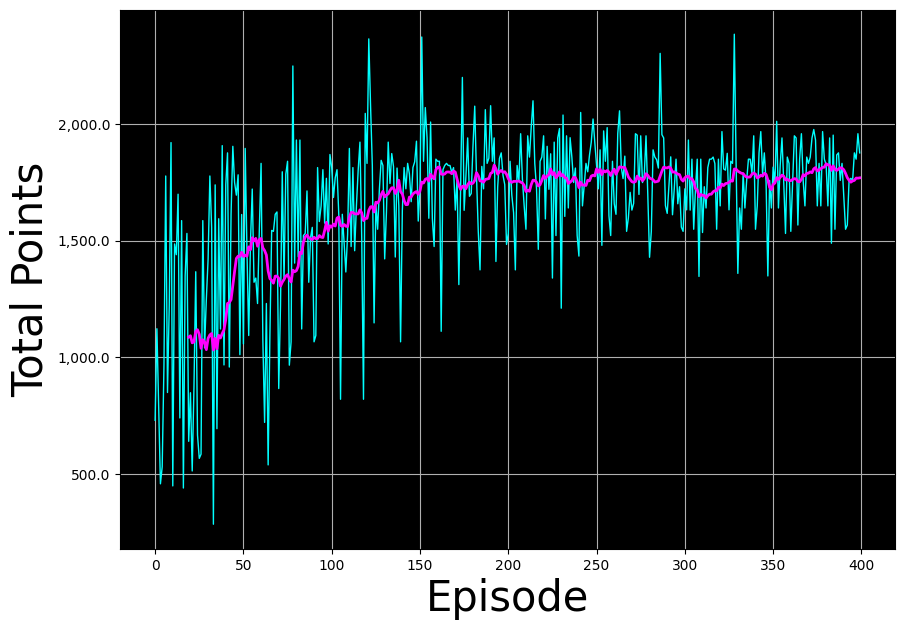

In [85]:
plot_history(total_point_history)

# Verificar Estado Final

In [90]:
import os
import numpy as np
import pandas as pd
import gym
from gym import spaces
from tensorflow.keras.models import load_model

In [95]:
import os

# Diretório que contém os arquivos
diretorio = '/content/unitario'

# Verifica se o diretório existe
if not os.path.exists(diretorio):
    # Se não existir, cria o diretório
    os.makedirs(diretorio)

# Itera sobre os arquivos no diretório
for arquivo in os.listdir(diretorio):
    # Verifica se o caminho é um arquivo
    if os.path.isfile(os.path.join(diretorio, arquivo)):
        # Remove o arquivo
        os.remove(os.path.join(diretorio, arquivo))

print("Todos os arquivos foram removidos com sucesso.")

Todos os arquivos foram removidos com sucesso.


In [92]:
def generate_matched_dataframes(compra_df, venda_df, output_path):
    compra_dataframes = []
    venda_dataframes = []

    for index, venda_row in venda_df.iterrows():
        filtered_compra_df = compra_df[
            (compra_df['Cód. Título'] == venda_row['Cód. Título']) &
            (compra_df['Cód. Corretora'] == venda_row['Cód. Corretora']) &
            (compra_df['Dt. Operação'] == venda_row['Dt. Operação'])
        ]

        if not filtered_compra_df.empty:
            compra_dataframes.append(filtered_compra_df)
            venda_dataframes.append(venda_df.iloc[[index]])

    for i in range(len(compra_dataframes)):
        compra_file = f'{output_path}/Compra{i+1}.xlsx'
        venda_file = f'{output_path}/Venda{i+1}.xlsx'
        compra_dataframes[i].to_excel(compra_file, index=False)
        venda_dataframes[i].to_excel(venda_file, index=False)

    return len(compra_dataframes)

# Caminhos das planilhas de entrada
spot_path = '/content/Compra.xlsx'
futures_path = '/content/Venda.xlsx'

# Lendo os dados
df_spot = pd.read_excel(spot_path)
df_futures = pd.read_excel(futures_path)

# Caminho para salvar as novas planilhas
output_path = '/content/unitario'

# Gerando e salvando os dataframes correspondentes
matched_sets_count = generate_matched_dataframes(df_spot, df_futures, output_path)


In [93]:
import warnings
import time

# Ignorar todos os avisos do TensorFlow
warnings.filterwarnings("ignore", category=FutureWarning, module='tensorflow')
warnings.filterwarnings("ignore", category=DeprecationWarning, module='tensorflow')

start_time = time.time()

erros = 0  # Inicializa o contador de erros
total_papeis = 0
papeis_entre_99_104 = 0
papeis_entre_99_5_100_5 = 0
papeis_fora_intervalo = 0
papeis_acima_de_100 = 0

# Define a quantidade de subplanilhas criadas
num_subplanilhas = 48  # ou a quantidade que você criou

# Carregar os dataframes das subplanilhas
compra_dfs = []
venda_dfs = []
for i in range(1, num_subplanilhas + 1):
    compra_path = f'/content/unitario/Compra{i}.xlsx'
    venda_path = f'/content/unitario/Venda{i}.xlsx'
    if os.path.exists(compra_path) and os.path.exists(venda_path):
        compra_dfs.append(pd.read_excel(compra_path))
        venda_dfs.append(pd.read_excel(venda_path))


# Loop pelas subplanilhas
for df_spot, df_futures in zip(compra_dfs, venda_dfs):
    try:
        total_papeis += 1  # Incrementa o contador de papéis processados

        # Adicionar uma coluna com o número dos dias úteis
        df_futures['DU'] = df_futures.apply(
            lambda row: business_days(row['Dt. Operação'], row['Vencimento'], bmf_calendar), axis=1)

        # Computar o Valor Presente (VP) do Preço com base na data de vencimento e na taxa DI do dia
        df_futures['VP Preço'] = df_futures['Preço'] / (1 + df_futures['DI']) ** (df_futures['DU'] / 252)

        # Carregar bases novas de teste e realizar o pré-processamento
        env = gym.make('CashAndCarryArbitrage-v0', df_futures=df_futures, df_spot=df_spot)

        state_size = (sum(1 for key, space in env.observation_space.spaces.items() if isinstance(space, spaces.Discrete))
                      + sum(np.prod(space.shape) for key, space in env.observation_space.spaces.items() if isinstance(space, spaces.Box)))

        num_actions = env.action_space.n

        # Load the trained model
        model = load_model('/content/cash_and_carry.h5')

        # Initialize the environment
        state = env.reset()
        state = convert_state_dict_to_array(state)
        state = np.reshape(state, [1, state_size])

        done = False
        total_reward = 0

        while not done:
            # Predict the best action from the trained model
            action = np.argmax(model.predict(state))

            # Take the action in the environment
            next_state, reward, done, _ = env.step(action)
            next_state = convert_state_dict_to_array(next_state)
            next_state = np.reshape(next_state, [1, state_size])

            state = next_state
            total_reward += reward

            if done:
                break

        # Close the environment
        env.close()

        # Calculating weighted averages
        weighted_averages = []
        for idx, future in enumerate(env.matches):
            total_quantity = 0
            weighted_sum = 0
            for quantity, weight in future:
                weighted_sum += quantity * weight
                total_quantity += quantity

            weighted_avg = (weighted_sum / total_quantity) * 100 if total_quantity else 0
            weighted_averages.append(weighted_avg)

        # Calculating standard deviation
        std_dev = np.std(weighted_averages)

        # Verificação do intervalo de rentabilidade
        rentabilidade_media = sum(weighted_averages) / len(weighted_averages)
        if 99.0 <= rentabilidade_media <= 104:
            papeis_entre_99_104 += 1
        if 99.5 <= rentabilidade_media <= 100.5:
            papeis_entre_99_5_100_5 += 1
        if rentabilidade_media >= 100:
            papeis_acima_de_100 += 1
        if not (99.0 <= rentabilidade_media <= 104):
            papeis_fora_intervalo += 1


    except Exception as e:
        print(f"Erro ao processar: {e}")
        erros += 1  # Incrementa o contador de erros
        continue  # Vai para a próxima iteração do loop

end_time = time.time()

execution_time = end_time - start_time

# Imprime os resultados
print(f"Quantidade total de papéis processados: {total_papeis}")
print(f"Quantidade de papéis entre 99% e 104%: {papeis_entre_99_104}")
print(f"Quantidade de papéis entre 99.5% e 100.5%: {papeis_entre_99_5_100_5}")
print(f"Quantidade de papéis fora do intervalo entre 99% e 104%: {papeis_fora_intervalo}")
print(f"Quantidade de papéis acima de 100%: {papeis_acima_de_100}")
print(f"CDI médio: {rentabilidade_media:.2f}%")
print(f"Tempo de execução: {execution_time:.2f} segundos")

1/1 [==============================] - 0s 62ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 65ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 92ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 95ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 73ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 68ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 61ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 62ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 74ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 65ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 67ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 58ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 67ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 58ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environme

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 61ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 63ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 57ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 56ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 61ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 93ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 84ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 97ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 95ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 89ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 95ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 61ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 66ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 55ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environme

1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 61ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 59ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 68ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 66ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 75ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 92ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 102ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 90ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 104ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 77ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 62ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 59ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environme

1/1 [==============================] - 0s 62ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 75ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 64ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 59ms/step
Quantidade total de papéis processados: 48
Quantidade de papéis entre 99% e 104%: 17
Quantidade de papéis entre 99.5% e 100.5%: 8
Quantidade de papéis fora do intervalo entre 99% e 104%: 31
Quantidade de papéis acima de 100%: 13
CDI médio: 100.42%
Tempo de execução: 37.54 segundos


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
